In [1]:
import pandas as pd
import joblib
import lifelines
import statsmodels
import dcurves
import numpy as np
from dcurves import dca, plot_graphs
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('Miller_2023_train_D_imputed.csv')
df_validate = pd.read_csv('Miller_2023_validate_D_imputed.csv')

In [3]:
df_train['REC_GRAFT_STAT'].value_counts(normalize=True)

REC_GRAFT_STAT
0.0    0.695299
1.0    0.304701
Name: proportion, dtype: float64

In [4]:
df_validate['REC_GRAFT_STAT'].value_counts(normalize = True)

REC_GRAFT_STAT
0.0    0.851741
1.0    0.148259
Name: proportion, dtype: float64

In [5]:
# Assuming df and df2 are already defined with a 'REC_CTR_CD' column

# Get the unique recipient center codes in both dataframes
unique_df_train = set(df_train['REC_CTR_CD'])
unique_df_validate = set(df_validate['REC_CTR_CD'])

# Remove rows in df1 where REC_CTR_CD is not in df2
df_train_filtered = df_train[df_train['REC_CTR_CD'].isin(unique_df_validate)]

# Remove rows in df2 where REC_CTR_CD is not in df1
df_validate_filtered = df_validate[df_validate['REC_CTR_CD'].isin(unique_df_train)]

In [6]:
df_train = df_train_filtered

df_validate = df_validate_filtered

In [7]:
df_train.shape

(67250, 16)

In [8]:
df_validate.shape

(37860, 16)

In [9]:
df_train['Graft_Survival_Time'] = (df_train['Graft_Survival_Time'])/364
df_validate['Graft_Survival_Time'] = (df_validate['Graft_Survival_Time'])/364

In [10]:
df_train.isnull().sum()
df_train.dropna(inplace=True)
df_validate.dropna(inplace=True)

In [11]:
from lifelines import CoxPHFitter

In [12]:
# DONOR-ONLY MODEL FITTED W/ RACE VARIABLE

cph = CoxPHFitter()

cph.fit(
    df_train,
    'Graft_Survival_Time',
    'REC_GRAFT_STAT',
    strata=['REC_CTR_CD'],
    show_progress=True,
    formula = ("DON_AGE + DON_RACE_SRTR + DON_CREAT + DON_HIST_HTN + DON_HIST_DB + DON_COD_DON_STROKE + DON_ANTI_HCV + DON_HGT_CM + DON_WGT_KG + DON_CARDIAC_ARREST_AFTER_DEATH")
)

cph.print_summary()

Iteration 1: norm_delta = 2.68e-01, step_size = 0.9500, log_lik = -115082.00714, newton_decrement = 6.90e+02, seconds_since_start = 1.3
Iteration 2: norm_delta = 1.75e-02, step_size = 0.9500, log_lik = -114408.90556, newton_decrement = 2.64e+00, seconds_since_start = 2.6
Iteration 3: norm_delta = 1.04e-03, step_size = 0.9500, log_lik = -114406.25737, newton_decrement = 1.09e-02, seconds_since_start = 3.9
Iteration 4: norm_delta = 1.66e-06, step_size = 1.0000, log_lik = -114406.24647, newton_decrement = 3.79e-08, seconds_since_start = 5.2
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 67044 total observations, 46576 right-censored observations>
             duration col = 'Graft_Survival_Time'
                event col = 'REC_GRAFT_STAT'
                   strata = REC_CTR_CD
      baseline estimation = breslow
   number of observations = 67044
number of events observed = 20468
   partial log-likelihood = -114406.25
         time fit was run = 2024-11-13 14:47:58 UTC

---
                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                       
DON_AGE                         0.01      1.01      0.00            0.01            0.01                1.01                1.01
DON_RACE_SRTR                   0.21      1.23      0.02            0.16            0.25                1.18                1.28
DON_CREAT                       0.06      1.06      0.01            0.04            0.08                1.04                1.09
DON_HIST_HTN                    0.11      1.12      0.02            0.07            0.15                1.08                1.16
DON_HIST_DB                     0.10      1.10      0.03            0.03            0.16                1.03                1.18
DON_COD_DON_STROKE              0.08      1.08      0.02            0.04            0.11                1.05                1.12
DON_ANTI_HCV                    0.50      1.64      0.05            0.41            0.59                1.50                1.80
DON_HGT_CM                     -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
DON_WGT_KG                     -0.00      1.00      0.00           -0.01           -0.00                0.99                1.00
DON_CARDIAC_ARREST_AFTER_DEATH -0.26      0.77      0.06           -0.37           -0.14                0.69                0.87

                                cmp to     z      p  -log2(p)
covariate                                                    
DON_AGE                           0.00 22.14 <0.005    358.40
DON_RACE_SRTR                     0.00  9.54 <0.005     69.30
DON_CREAT                         0.00  5.20 <0.005     22.24
DON_HIST_HTN                      0.00  6.01 <0.005     28.98
DON_HIST_DB                       0.00  2.83 <0.005      7.77
DON_COD_DON_STROKE                0.00  4.51 <0.005     17.24
DON_ANTI_HCV                      0.00 10.85 <0.005     88.73
DON_HGT_CM                        0.00 -5.52 <0.005     24.79
DON_WGT_KG                        0.00 -8.57 <0.005     56.49
DON_CARDIAC_ARREST_AFTER_DEATH    0.00 -4.32 <0.005     15.96
---
Concordance = 0.58
Partial AIC = 228832.49
log-likelihood ratio test = 1351.52 on 10 df
-log2(p) of ll-ratio test = 941.89

In [13]:
cph_pred_vals = \
    cph.predict_survival_function(df_validate,
                                    times = [5])


                                   
df_validate['graft_failure_5_years'] = [1-val for val in cph_pred_vals.iloc[0,:]]

/Users/aleishakhan/.pyenv/versions/3.10.12/envs/py310_env/lib/python3.10/site-packages/dcurves/risks.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  risks_df[modelname].replace(
/Users/aleishakhan/.pyenv/versions/3.10.12/envs/py310_env/lib/python3.10/site-packages/dcurves/risks.py:157: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object o

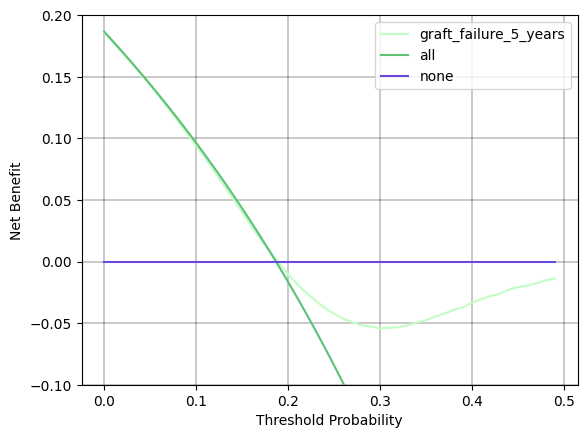

In [14]:
stdca_coxph_results = \
          dca(
              data=df_validate,
              outcome='REC_GRAFT_STAT',
              modelnames=['graft_failure_5_years'],
              thresholds=np.arange(0, 0.5, 0.01),
              time=5,
              time_to_outcome_col='Graft_Survival_Time'
          )
  
plot_graphs(
    plot_df=stdca_coxph_results,
    graph_type='net_benefit',
    y_limits=[-0.1, 0.2]
  )

In [15]:
  dca_table_df = \
      dca(
          data=df_validate,
          outcome='REC_GRAFT_STAT',
          modelnames=['graft_failure_5_years'],
          models_to_prob=['graft_failure_5_years'],
          thresholds=np.arange(0, 1, 0.1)
      )
  
  print('\n', dca_table_df[['model', 'threshold', 'net_benefit']])



                     model  threshold  net_benefit
0   graft_failure_5_years        0.0     0.148667
1   graft_failure_5_years        0.1     0.054075
2   graft_failure_5_years        0.2     0.000000
3   graft_failure_5_years        0.3     0.000000
4   graft_failure_5_years        0.4     0.000000
5   graft_failure_5_years        0.5     0.000000
6   graft_failure_5_years        0.6     0.000000
7   graft_failure_5_years        0.7     0.000000
8   graft_failure_5_years        0.8     0.000000
9   graft_failure_5_years        0.9     0.000000
10                    all        0.0     0.148667
11                    all        0.1     0.054075
12                    all        0.2    -0.064166
13                    all        0.3    -0.216190
14                    all        0.4    -0.418888
15                    all        0.5    -0.702666
16                    all        0.6    -1.128332
17                    all        0.7    -1.837776
18                    all        0.8    -3.25666

/Users/aleishakhan/.pyenv/versions/3.10.12/envs/py310_env/lib/python3.10/site-packages/dcurves/risks.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  risks_df[modelname].replace(
/Users/aleishakhan/.pyenv/versions/3.10.12/envs/py310_env/lib/python3.10/site-packages/dcurves/risks.py:157: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object o

# Translate KDRI (relative risk of failure compared to median donor) into KDPI

In [16]:
coefficients = cph.params_
print(coefficients)

covariate
DON_AGE                           0.012239
DON_RACE_SRTR                     0.205530
DON_CREAT                         0.061122
DON_HIST_HTN                      0.111011
DON_HIST_DB                       0.096607
DON_COD_DON_STROKE                0.077991
DON_ANTI_HCV                      0.496717
DON_HGT_CM                       -0.003260
DON_WGT_KG                       -0.004085
DON_CARDIAC_ARREST_AFTER_DEATH   -0.256715
Name: coef, dtype: float64


In [17]:

# Define a function to calculate KDRI for a given donor's data row
def calculate_kdri(row, coefficients):
    log_hazard = sum(coefficients[var] * row[var] for var in coefficients.index)
    kdri = np.exp(log_hazard)
    return kdri

# Apply the function to your dataset
df_validate['KDRI'] = df_validate.apply(lambda row: calculate_kdri(row, coefficients), axis=1)


#Calculate KDPI: 
# Function to calculate KDPI from KDRI using the reference distribution
reference_kdri = np.sort(df_validate['KDRI'].values)

def calculate_kdpi(kdri, reference_kdri):
    # Calculate the percentile rank (KDPI) for the given KDRI
    percentile = (np.sum(reference_kdri <= kdri) / len(reference_kdri)) * 100
    return percentile

# Apply the function to your dataset to create the KDPI column
df_validate['KDPI'] = df_validate['KDRI'].apply(lambda x: calculate_kdpi(x, reference_kdri))



In [18]:
df_validate.head()




,TRR_ID,DON_AGE,DON_RACE_SRTR,DON_CREAT,DON_HIST_HTN,DON_HIST_DB,DON_COD_DON_STROKE,DON_ANTI_HCV,DON_HGT_CM,DON_WGT_KG,DON_CARDIAC_ARREST_AFTER_DEATH,Graft_Survival_Time,REC_GRAFT_STAT,REC_CTR_CD,REC_DIAB,REC_AGE_AT_TX,graft_failure_5_years,KDRI,KDPI
0,539454,18,0,1.1,0.0,0.0,1,0.0,156.9999,49.0,0.0,0.489011,0.0,FLFH,0,56,0.235015,0.707183,35.844616
1,535765,26,0,0.8,0.0,0.0,0,1.0,175.2600,77.0,0.0,11.310440,0.0,MDJH,0,56,0.326430,0.978175,76.113285
2,529954,52,0,0.7,0.0,0.0,1,0.0,167.6400,76.2,0.0,0.596154,0.0,OKSF,0,67,0.157067,0.904320,66.688703
3,538471,55,0,1.3,0.0,0.0,1,0.0,180.3400,65.1,0.0,0.310440,0.0,PAAE,0,53,0.205975,0.977025,75.986355
4,534623,52,0,1.4,1.0,0.0,0,0.0,185.4200,131.0,0.0,0.574176,0.0,ILNM,0,51,0.108846,0.735959,40.985297


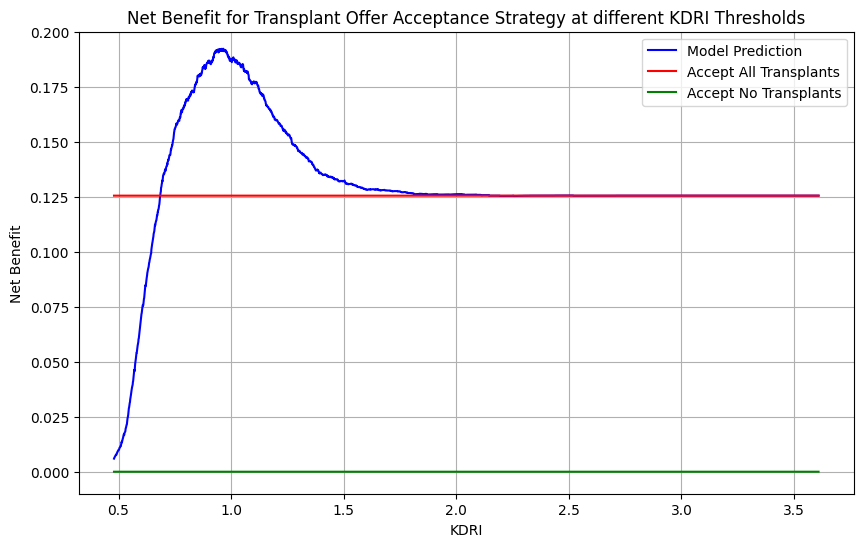

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set threshold range for KDRI
kdri_thresholds = np.arange(0.48, 3.61, 0.001)  # Thresholds to evaluate (based on 2010 OPTN mapp8ing table)
N = len(df_validate)  # Total number of patients

# Initialize lists to store net benefit values for each strategy
net_benefit_model = []
net_benefit_accept_all = []
net_benefit_accept_none = []  # Always 0 as no transplants are accepted

# Set the desired probability threshold for survival benefit (e.g., 83% threshold for net benefit calculation)
desired_probability = 0.83
odds_ratio = desired_probability / (1 - desired_probability)  # Converts 0.83 to an odds ratio

# Precompute total positives (graft survivals) and negatives (graft failures) in the data
total_negatives = df_validate['REC_GRAFT_STAT'].sum()  # Total graft failures
total_positives = N - total_negatives  # Total graft survivals

# Precompute "Accept All" net benefit value, since it doesn't change across thresholds
TP_accept_all = (df_validate['REC_GRAFT_STAT'] == 0).sum()  # Correctly predicted graft survivals
FN_accept_all = (df_validate['REC_GRAFT_STAT'] == 1).sum()  # Actual graft failures
net_benefit_accept_all_value = (TP_accept_all / N) - (FN_accept_all / N) * odds_ratio

# Loop over each threshold in kdri_thresholds
for threshold in kdri_thresholds:
    # Vectorized calculations for TP and FP based on the current threshold
    is_below_threshold = df_validate['KDRI'] < threshold
    TP = ((is_below_threshold) & (df_validate['REC_GRAFT_STAT'] == 0)).sum()  # True Positives (survivals correctly identified)
    FP = ((is_below_threshold) & (df_validate['REC_GRAFT_STAT'] == 1)).sum()  # False Positives (failures incorrectly predicted as survivals)

    # Calculate net benefit for model strategy at the current threshold
    net_benefit_model_value = (TP / N) - (FP / N) * odds_ratio
    net_benefit_model.append(net_benefit_model_value)

    # Store "Accept All" and "Accept None" values
    net_benefit_accept_all.append(net_benefit_accept_all_value)
    net_benefit_accept_none.append(0)  # Always zero for "Accept None" strategy

# Plot the results for different thresholds
plt.figure(figsize=(10, 6))
plt.plot(kdri_thresholds, net_benefit_model, 'b-', label='Model Prediction')
plt.plot(kdri_thresholds, net_benefit_accept_all, 'r-', label='Accept All Transplants')
plt.plot(kdri_thresholds, net_benefit_accept_none, 'g-', label='Accept No Transplants')

plt.xlabel("KDRI")
plt.ylabel("Net Benefit")
plt.title("Net Benefit for Transplant Offer Acceptance Strategy at different KDRI Thresholds")
plt.ylim(-0.01, 0.2)
plt.legend()
plt.grid(True)
plt.show()



# Donor Only without race term

In [20]:
df_train = df_train.drop('DON_RACE_SRTR', axis=1)
df_validate = df_validate.drop('DON_RACE_SRTR', axis=1)

In [21]:
# DONOR-ONLY MODEL FITTED WITHOUT RACE TERM

cph1 = CoxPHFitter()

cph1.fit(
    df_train,
    'Graft_Survival_Time',
    'REC_GRAFT_STAT',
    strata=['REC_CTR_CD'],
    show_progress=True,
    formula = ("DON_AGE + DON_CREAT + DON_HIST_HTN + DON_HIST_DB + DON_COD_DON_STROKE + DON_ANTI_HCV + DON_HGT_CM + DON_WGT_KG + DON_CARDIAC_ARREST_AFTER_DEATH")
)

cph1.print_summary()

Iteration 1: norm_delta = 2.53e-01, step_size = 0.9500, log_lik = -115082.00714, newton_decrement = 6.45e+02, seconds_since_start = 1.3
Iteration 2: norm_delta = 1.67e-02, step_size = 0.9500, log_lik = -114452.34110, newton_decrement = 2.49e+00, seconds_since_start = 2.6
Iteration 3: norm_delta = 9.99e-04, step_size = 0.9500, log_lik = -114449.83549, newton_decrement = 1.03e-02, seconds_since_start = 4.0
Iteration 4: norm_delta = 1.59e-06, step_size = 1.0000, log_lik = -114449.82514, newton_decrement = 3.46e-08, seconds_since_start = 5.4
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 67044 total observations, 46576 right-censored observations>
             duration col = 'Graft_Survival_Time'
                event col = 'REC_GRAFT_STAT'
                   strata = REC_CTR_CD
      baseline estimation = breslow
   number of observations = 67044
number of events observed = 20468
   partial log-likelihood = -114449.83
         time fit was run = 2024-11-13 14:48:16 UTC

---
                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                       
DON_AGE                         0.01      1.01      0.00            0.01            0.01                1.01                1.01
DON_CREAT                       0.07      1.07      0.01            0.05            0.09                1.05                1.10
DON_HIST_HTN                    0.12      1.13      0.02            0.09            0.16                1.09                1.17
DON_HIST_DB                     0.10      1.10      0.03            0.03            0.16                1.03                1.18
DON_COD_DON_STROKE              0.08      1.09      0.02            0.05            0.12                1.05                1.13
DON_ANTI_HCV                    0.50      1.65      0.05            0.41            0.59                1.51                1.80
DON_HGT_CM                     -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
DON_WGT_KG                     -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
DON_CARDIAC_ARREST_AFTER_DEATH -0.26      0.77      0.06           -0.37           -0.14                0.69                0.87

                                cmp to     z      p  -log2(p)
covariate                                                    
DON_AGE                           0.00 21.14 <0.005    327.03
DON_CREAT                         0.00  5.89 <0.005     27.96
DON_HIST_HTN                      0.00  6.73 <0.005     35.81
DON_HIST_DB                       0.00  2.83 <0.005      7.73
DON_COD_DON_STROKE                0.00  4.87 <0.005     19.75
DON_ANTI_HCV                      0.00 10.91 <0.005     89.59
DON_HGT_CM                        0.00 -5.49 <0.005     24.54
DON_WGT_KG                        0.00 -8.47 <0.005     55.23
DON_CARDIAC_ARREST_AFTER_DEATH    0.00 -4.32 <0.005     15.99
---
Concordance = 0.57
Partial AIC = 228917.65
log-likelihood ratio test = 1264.36 on 9 df
-log2(p) of ll-ratio test = 883.01

In [22]:
cph1_pred_vals = \
    cph1.predict_survival_function(df_validate,
                                    times = [5])


                                   
df_validate['graft_failure_5_years'] = [1-val for val in cph1_pred_vals.iloc[0,:]]

/Users/aleishakhan/.pyenv/versions/3.10.12/envs/py310_env/lib/python3.10/site-packages/dcurves/risks.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  risks_df[modelname].replace(
/Users/aleishakhan/.pyenv/versions/3.10.12/envs/py310_env/lib/python3.10/site-packages/dcurves/risks.py:157: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object o

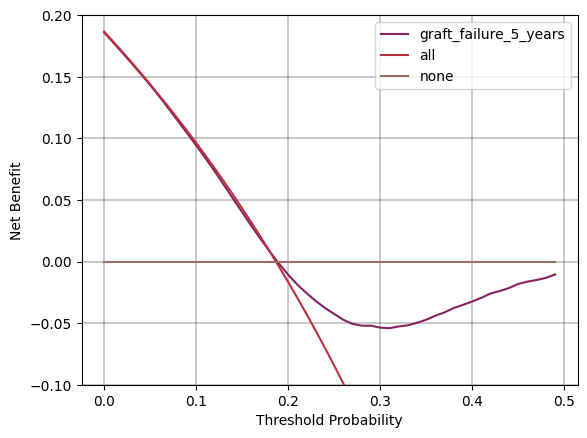

In [23]:
stdca_coxph_results = \
          dca(
              data=df_validate,
              outcome='REC_GRAFT_STAT',
              modelnames=['graft_failure_5_years'],
              thresholds=np.arange(0, 0.5, 0.01),
              time=5,
              time_to_outcome_col='Graft_Survival_Time'
          )
  
plot_graphs(
    plot_df=stdca_coxph_results,
    graph_type='net_benefit',
    y_limits=[-0.1, 0.2]
  )

In [24]:
coefficients = cph1.params_
print(coefficients)

covariate
DON_AGE                           0.011589
DON_CREAT                         0.068441
DON_HIST_HTN                      0.124019
DON_HIST_DB                       0.096326
DON_COD_DON_STROKE                0.084071
DON_ANTI_HCV                      0.499198
DON_HGT_CM                       -0.003247
DON_WGT_KG                       -0.004039
DON_CARDIAC_ARREST_AFTER_DEATH   -0.256943
Name: coef, dtype: float64


In [25]:

# Define a function to calculate KDRI for a given donor's data row
def calculate_kdri(row, coefficients):
    log_hazard = sum(coefficients[var] * row[var] for var in coefficients.index)
    kdri = np.exp(log_hazard)
    return kdri

# Apply the function to your dataset
df_validate['KDRI'] = df_validate.apply(lambda row: calculate_kdri(row, coefficients), axis=1)


#Calculate KDPI: 
# Function to calculate KDPI from KDRI using the reference distribution
reference_kdri = np.sort(df_validate['KDRI'].values)

def calculate_kdpi(kdri, reference_kdri):
    # Calculate the percentile rank (KDPI) for the given KDRI
    percentile = (np.sum(reference_kdri <= kdri) / len(reference_kdri)) * 100
    return percentile

# Apply the function to your dataset to create the KDPI column
df_validate['KDPI'] = df_validate['KDRI'].apply(lambda x: calculate_kdpi(x, reference_kdri))

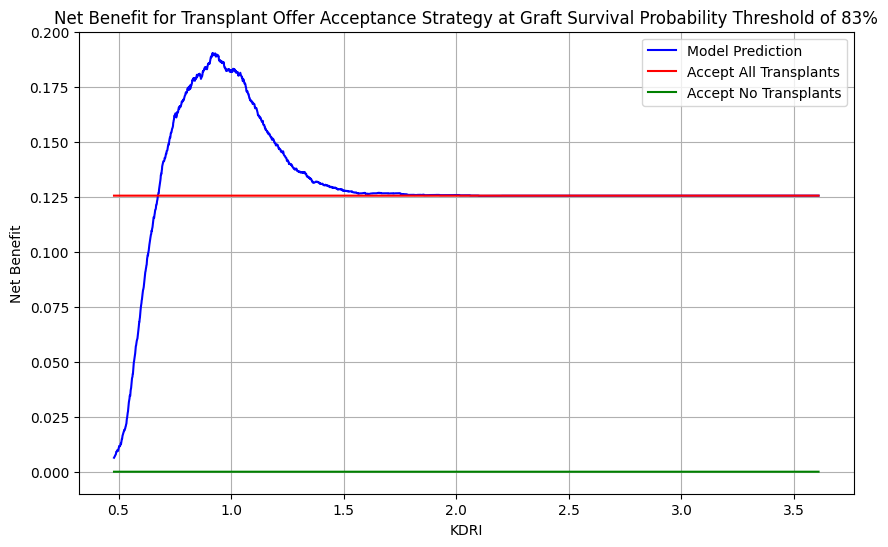

In [26]:

# Set threshold range for KDRI
kdri_thresholds = np.arange(0.48, 3.61, 0.001)
N = len(df_validate)

# Initialize net benefit lists
net_benefit_model = []
net_benefit_accept_all = []
net_benefit_accept_none = []

# Calculate total positives and negatives
total_negatives = df_validate['REC_GRAFT_STAT'].sum()
total_positives = N - total_negatives

# Pre-compute net benefit values for Accept All strategy
TP_accept_all = (df_validate['REC_GRAFT_STAT'] == 0).sum()
FN_accept_all = (df_validate['REC_GRAFT_STAT'] == 1).sum()
fixed_accept_all_net_benefit = (TP_accept_all / N) - (FN_accept_all / N) * (0.83 / (1 - 0.83))

# Loop over each KDRI threshold to calculate net benefit for the model
for threshold in kdri_thresholds:
    # Vectorized calculation of TP and FP based on current threshold
    is_below_threshold = df_validate['KDRI'] < threshold
    TP = ((is_below_threshold) & (df_validate['REC_GRAFT_STAT'] == 0)).sum()
    FP = ((is_below_threshold) & (df_validate['REC_GRAFT_STAT'] == 1)).sum()

    # Calculate net benefit for model strategy
    net_benefit_model_value = (TP / N) - (FP / N) * (0.83 / (1 - 0.83))
    net_benefit_model.append(net_benefit_model_value)

    # Append precomputed values for accept all and accept none
    net_benefit_accept_all.append(fixed_accept_all_net_benefit)
    net_benefit_accept_none.append(0)  # Accept None is always zero

# Plot the results for different thresholds
plt.figure(figsize=(10, 6))
plt.plot(kdri_thresholds, net_benefit_model, 'b-', label='Model Prediction')
plt.plot(kdri_thresholds, net_benefit_accept_all, 'r-', label='Accept All Transplants')
plt.plot(kdri_thresholds, net_benefit_accept_none, 'g-', label='Accept No Transplants')

plt.xlabel("KDRI")
plt.ylabel("Net Benefit")
plt.title("Net Benefit for Transplant Offer Acceptance Strategy at Graft Survival Probability Threshold of 83%")
plt.ylim(-0.01, 0.2)
plt.legend()
plt.grid(True)
plt.show()

    
